## IMPORTING MODULES:

In [1]:
import numpy as np
import pandas as pd
import string
import re
import matplotlib.pyplot as plt

import nltk
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
from nltk.tokenize import sent_tokenize, word_tokenize
stopwords = nltk.corpus.stopwords.words('english')

import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer # initialises an array of frequencies of words.

from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix, recall_score, precision_score, roc_curve
from wordcloud import WordCloud
%matplotlib inline
import sklearn.metrics as metrics
from plot_metric.functions import BinaryClassification
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import xgboost as xgb
from vecstack import stacking
import contractions
from plot_metric.functions import BinaryClassification


## LOADING THE DATASET:

In [2]:
df = pd.read_csv('comments1.csv')
df2 = pd.DataFrame(columns=['Algorithm','Accuracy','F1', 'Precision', 'Recall'])
df.head(5)
processed_text = []

In [3]:
#Non-hate
(df['final_isHate'] == 0).sum()

3858

In [4]:
#Hate
(df['final_isHate'] == 1).sum()

1142

## PRE-PROCESSING TEXT:

In [5]:
df['Comment'] = df['Comment'].apply(lambda x: contractions.fix(x))
df.head()

,Comment,final_isHate
0,Dennis Stevens we are living in the EndTimes.p...,0
1,@IAmAgainst these are not just feminist but mo...,1
2,I am SO grateful you used footage from the BBC...,0
3,"First rule in liar 101, do not act guilty. Any...",0
4,@jonnyjoejack gave you cancer? I said I was an...,0


In [6]:
comments= df.Comment
def preprocess(tweet):  
    
    # removal of extra spaces
    regex_pat = re.compile(r'\s+')
    tweet_space = tweet.str.replace(regex_pat, ' ')

    # removal of @name[mention]
    regex_pat = re.compile(r'@[\w\-]+')
    tweet_name = tweet_space.str.replace(regex_pat, '')
    
    # removal of capitalization
    tweet_lower = tweet_name.str.lower()
    
    # removal of links[https://abc.com]
    giant_url_regex =  re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
            '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    tweets = tweet_lower.str.replace(giant_url_regex, '')
    
    # removal of punctuations and numbers
    punc_remove = tweets.str.replace("[^a-zA-Z]", " ")
    
    # remove whitespace with a single space
    new_tweet= punc_remove.str.replace(r'\s+', ' ')
    
    # remove leading and trailing whitespace
    new_tweet= new_tweet.str.replace(r'^\s+|\s+?$','')
    
    # replace normal numbers with numbr
    #newtweet=newtweet.str.replace(r'\d+(\.\d+)?','numbr')
    
    
    # tokenizing
    tokenized_tweet = new_tweet.apply(lambda x: x.split())
        
    # removal of stopwords
    tokenized_tweet=  tokenized_tweet.apply(lambda x: [item for item in x if item not in stopwords])
        
    # stemming of the tweets
    tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) 
        
    for i in range(len(tokenized_tweet)):
        tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
        tweets_p= tokenized_tweet
    
    return tweets_p

processed_comments = preprocess(comments)   

df['Comment'] = processed_comments
df.head(10)

,Comment,final_isHate
0,denni steven live endtim peopl turn love one a...,0
1,feminist mostli lesbian hostil men especi rela...,1
2,grate use footag bbc p p keira knightley crapo...,0
3,first rule liar act guilti anyon els detect ma...,0
4,gave cancer said annoy cancel oh typo happen,0
5,seem littl suspici,0
6,innoc matter color,0
7,love nice rom com time time make feel happi,0
8,jim beicker clearli murder cover killer wrong,0
9,yeah great still find rewatch live concert ser...,0


In [7]:
processed_comments

0       denni steven live endtim peopl turn love one a...
1       feminist mostli lesbian hostil men especi rela...
2       grate use footag bbc p p keira knightley crapo...
3       first rule liar act guilti anyon els detect ma...
4            gave cancer said annoy cancel oh typo happen
                              ...                        
4995                                         yaazz si say
4996         go talk gorgeou actual soo beauti mashallahh
4997    ye spill tea si liter assum guy muslim good go...
4998    video request mind vlog day life etc lookbook ...
4999                                           eye grey f
Name: Comment, Length: 5000, dtype: object

## EXPLORATORY DATA ANALYSIS:

In [8]:
all_words = " ".join([sentence for sentence in df['Comment']])

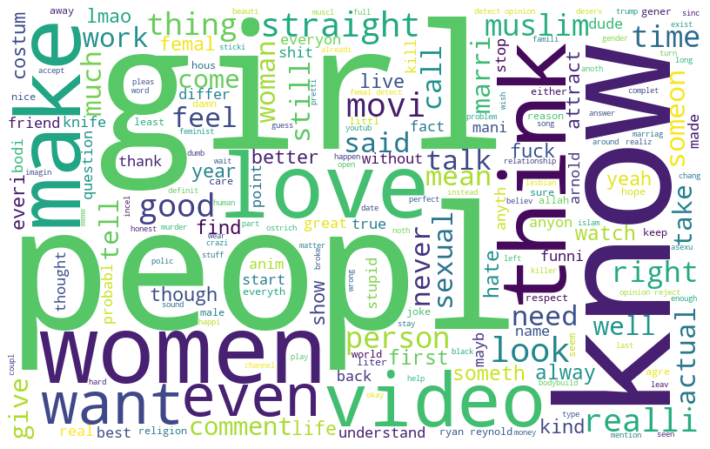

In [9]:
wordcloud_pos = WordCloud(width=800, height=500, random_state=42, max_font_size=200, min_word_length=4, background_color='white').generate(all_words)

# plot the graph
plt.figure(figsize=(15,8))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.show()

In [10]:
sent = SentimentIntensityAnalyzer()
polarity = [round(sent.polarity_scores(i)['compound'], 2) for i in df['Comment']]
df['sentiment_score'] = polarity
df.head()

,Comment,final_isHate,sentiment_score
0,denni steven live endtim peopl turn love one a...,0,0.64
1,feminist mostli lesbian hostil men especi rela...,1,0.00
2,grate use footag bbc p p keira knightley crapo...,0,0.64
3,first rule liar act guilti anyon els detect ma...,0,0.34
4,gave cancer said annoy cancel oh typo happen,0,-0.85


In [11]:
df[["sentiment_score"]].describe()

,sentiment_score
count,5000.000000
mean,0.078656
std,0.415667
min,-0.980000
25%,0.000000
50%,0.000000
75%,0.380000
max,0.990000


In [12]:
def sentiment(x):
    if x<0:
        return 'Negative'
    
    else:
        return 'Positive'
    
df['Polarity']=df['sentiment_score'].map(lambda x: sentiment(x))
df.head()

,Comment,final_isHate,sentiment_score,Polarity
0,denni steven live endtim peopl turn love one a...,0,0.64,Positive
1,feminist mostli lesbian hostil men especi rela...,1,0.00,Positive
2,grate use footag bbc p p keira knightley crapo...,0,0.64,Positive
3,first rule liar act guilti anyon els detect ma...,0,0.34,Positive
4,gave cancer said annoy cancel oh typo happen,0,-0.85,Negative


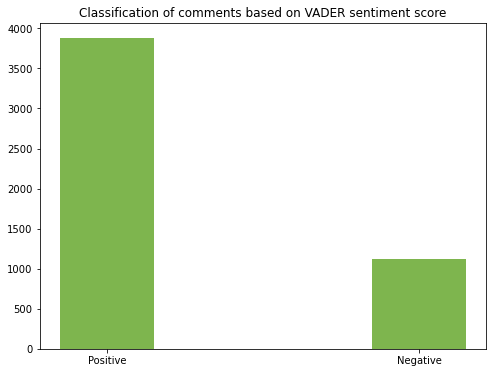

In [13]:



plt.rcParams["figure.figsize"] = [8, 6]
width = 0.3
fig, ax = plt.subplots()

pps = ax.bar(df.Polarity.value_counts().index, df.Polarity.value_counts(), width, align='center', color='#7eb54e')
plt.title('Classification of comments based on VADER sentiment score')
plt.show()

In [14]:
X = df["Comment"]
X.head()

0    denni steven live endtim peopl turn love one a...
1    feminist mostli lesbian hostil men especi rela...
2    grate use footag bbc p p keira knightley crapo...
3    first rule liar act guilti anyon els detect ma...
4         gave cancer said annoy cancel oh typo happen
Name: Comment, dtype: object

In [15]:
y = df["final_isHate"]
y.head()

0    0
1    1
2    0
3    0
4    0
Name: final_isHate, dtype: int64

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [17]:
vectorizer = TfidfVectorizer(max_df=0.8, min_df=6, max_features=3000, stop_words=stopwords, ngram_range=(1,1))

In [18]:
X_train_cv1 = vectorizer.fit_transform(X_train) # Learn the vocabulary dictionary and return term-document matrix
X_test_cv1  = vectorizer.transform(X_test)

### Random Forest:

In [19]:
from sklearn.ensemble import RandomForestClassifier #supervised-learning
model_rf = RandomForestClassifier(random_state=0, n_estimators=140)    
model_rf.fit(X_train_cv1, y_train) 

RandomForestClassifier(n_estimators=140, random_state=0)

In [20]:
predictions = model_rf.predict(X_test_cv1)

In [21]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.83      0.95      0.89       782
           1       0.62      0.32      0.42       218

    accuracy                           0.81      1000
   macro avg       0.73      0.63      0.65      1000
weighted avg       0.79      0.81      0.78      1000



In [22]:
conf_matrix= confusion_matrix(y_test, predictions)
print(conf_matrix)

[[740  42]
 [149  69]]


In [23]:
print(accuracy_score(y_test, predictions))

0.809


In [24]:
print(f1_score(y_test, predictions))

0.4194528875379939


In [25]:
print(precision_score(y_test, predictions))

0.6216216216216216


In [26]:
print(recall_score(y_test, predictions))

0.3165137614678899


In [27]:
df3 = {'Algorithm': 'Random Forest', 'Accuracy': accuracy_score(y_test, predictions)*100, 'F1': f1_score(y_test, predictions)*100, 'Precision': precision_score(y_test, predictions)*100, 'Recall': recall_score(y_test, predictions)*100}
df2 = df2.append(df3, ignore_index = True)

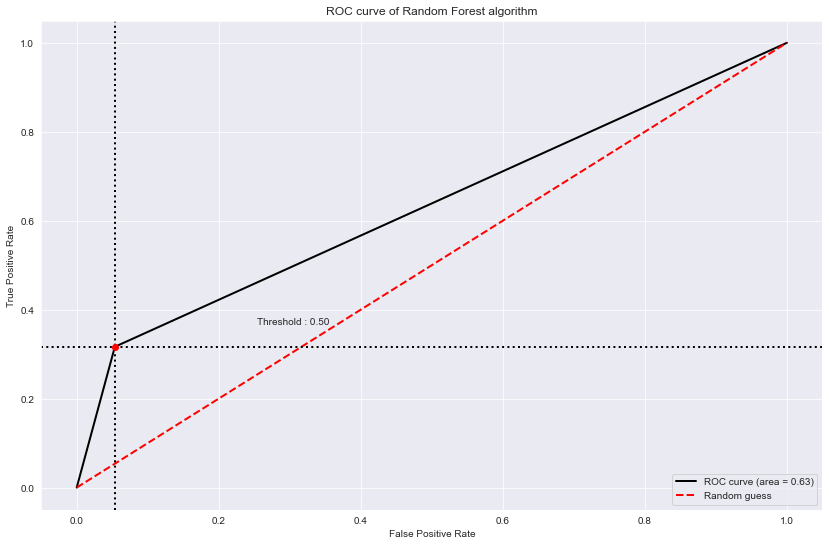

In [28]:
bc = BinaryClassification(y_test, predictions, labels=None)
plt.figure(figsize=(14, 9))
bc.plot_roc_curve()
plt.title('ROC curve of Random Forest algorithm')
plt.show()

### Logistic Regression:

In [29]:
from sklearn.linear_model import LogisticRegression
model_lr = LogisticRegression()
model_lr.fit(X_train_cv1, y_train) 

LogisticRegression()

In [30]:
predictions = model_lr.predict(X_test_cv1)

In [31]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.82      0.98      0.89       782
           1       0.79      0.21      0.33       218

    accuracy                           0.81      1000
   macro avg       0.80      0.60      0.61      1000
weighted avg       0.81      0.81      0.77      1000



In [32]:
conf_matrix= confusion_matrix(y_test, predictions)
print(conf_matrix)

[[770  12]
 [173  45]]


In [33]:
print(accuracy_score(y_test, predictions))

0.815


In [34]:
print(f1_score(y_test, predictions))

0.3272727272727273


In [35]:
print(precision_score(y_test, predictions))

0.7894736842105263


In [36]:
print(recall_score(y_test, predictions))

0.20642201834862386


In [37]:
df4 = {'Algorithm': 'Logistic Regression', 'Accuracy': accuracy_score(y_test, predictions)*100, 'F1': f1_score(y_test, predictions)*100, 'Precision': precision_score(y_test, predictions)*100, 'Recall': recall_score(y_test, predictions)*100}
df2 = df2.append(df4, ignore_index = True)

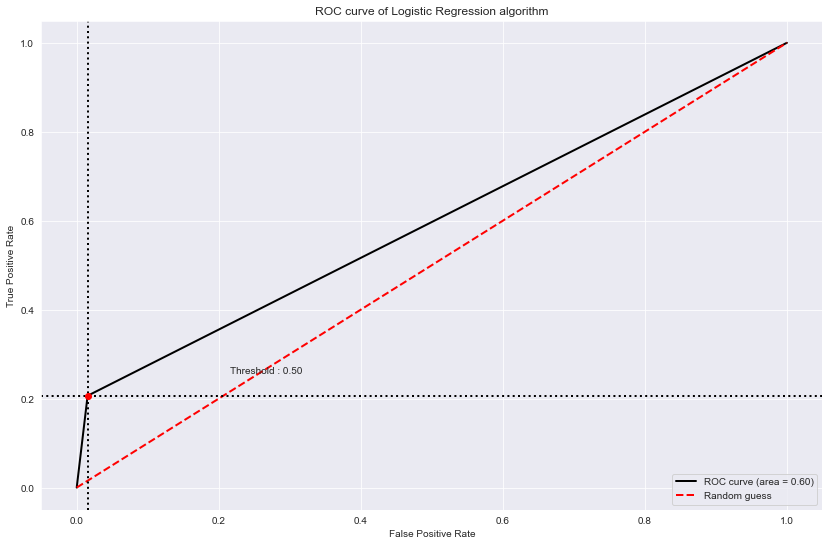

In [38]:
bc = BinaryClassification(y_test, predictions, labels=None)
plt.figure(figsize=(14, 9))
bc.plot_roc_curve()
plt.title('ROC curve of Logistic Regression algorithm')
plt.show()

### XGBOOST:

In [39]:
from xgboost import XGBClassifier

model_xgb = XGBClassifier(base_score=0.35)
model_xgb.fit(X_train_cv1, y_train) 

XGBClassifier(base_score=0.35, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [40]:
predictions = model_xgb.predict(X_test_cv1)

In [41]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.84      0.96      0.89       782
           1       0.69      0.32      0.44       218

    accuracy                           0.82      1000
   macro avg       0.76      0.64      0.67      1000
weighted avg       0.80      0.82      0.79      1000



In [42]:
conf_matrix= confusion_matrix(y_test, predictions)
print(conf_matrix)

[[751  31]
 [148  70]]


In [43]:
print(precision_score(y_test, predictions))

0.693069306930693


In [44]:
print(f1_score(y_test, predictions))

0.43887147335423193


In [45]:
print(precision_score(y_test, predictions))

0.693069306930693


In [46]:
print(recall_score(y_test, predictions))

0.3211009174311927


In [47]:
df5 = {'Algorithm': 'XGBoost', 'Accuracy': accuracy_score(y_test, predictions)*100, 'F1': f1_score(y_test, predictions)*100, 'Precision': precision_score(y_test, predictions)*100, 'Recall': recall_score(y_test, predictions)*100}
df2 = df2.append(df5, ignore_index = True)

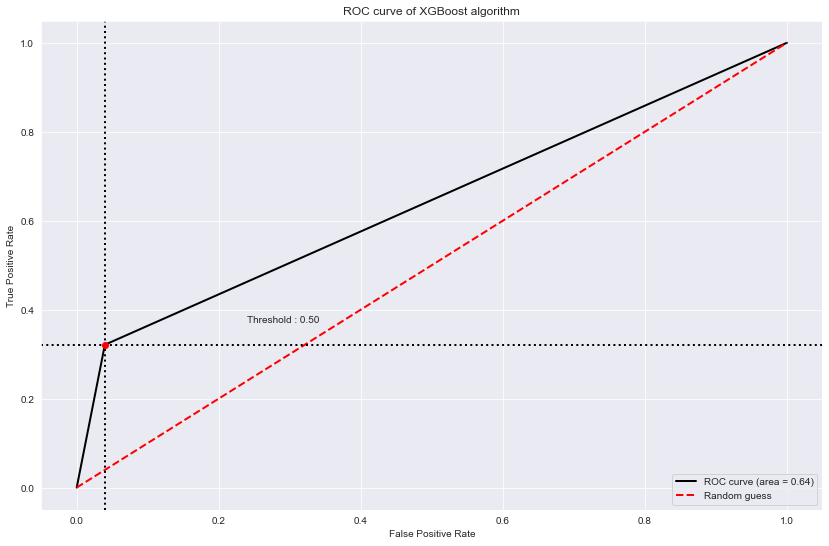

In [48]:
bc = BinaryClassification(y_test, predictions, labels=None)
plt.figure(figsize=(14, 9))
bc.plot_roc_curve()
plt.title('ROC curve of XGBoost algorithm')
plt.show()

### Naive Bayes:

In [49]:
from sklearn.naive_bayes import MultinomialNB
model_nb = MultinomialNB()
model_nb.fit(X_train_cv1, y_train)

MultinomialNB()

In [50]:
predictions = model_nb.predict(X_test_cv1)

In [51]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.81      0.99      0.89       782
           1       0.83      0.18      0.29       218

    accuracy                           0.81      1000
   macro avg       0.82      0.58      0.59      1000
weighted avg       0.82      0.81      0.76      1000



In [52]:
conf_matrix= confusion_matrix(y_test, predictions)
print(conf_matrix)

[[774   8]
 [179  39]]


In [53]:
print(accuracy_score(y_test, predictions))

0.813


In [54]:
print(f1_score(y_test, predictions))

0.2943396226415095


In [55]:
print(precision_score(y_test, predictions))

0.8297872340425532


In [56]:
print(recall_score(y_test, predictions))

0.17889908256880735


In [57]:
df6 = {'Algorithm': 'Naive Bayes', 'Accuracy': accuracy_score(y_test, predictions)*100, 'F1': f1_score(y_test, predictions)*100, 'Precision': precision_score(y_test, predictions)*100, 'Recall': recall_score(y_test, predictions)*100}
df2 = df2.append(df6, ignore_index = True)

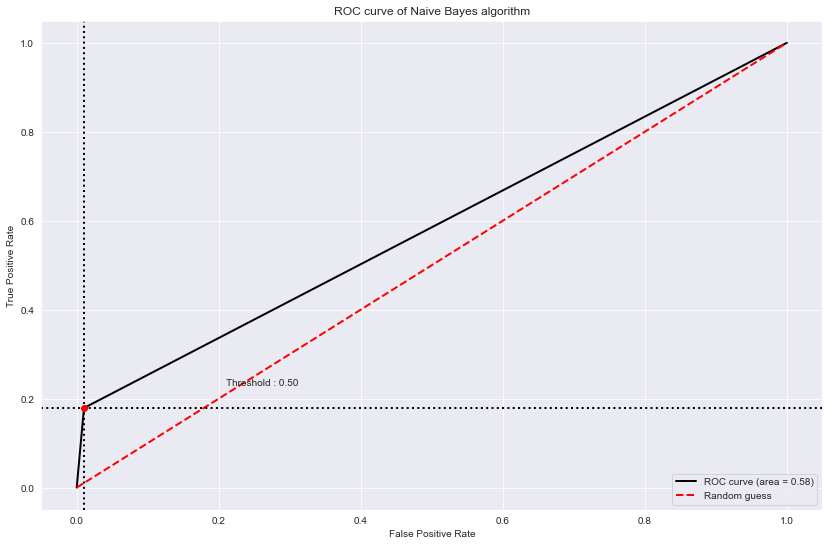

In [58]:
bc = BinaryClassification(y_test, predictions, labels=None)
plt.figure(figsize=(14, 9))
bc.plot_roc_curve()
plt.title('ROC curve of Naive Bayes algorithm')
plt.show()

### STACKING

In [59]:
from mlxtend.classifier import StackingClassifier

clf_stack = StackingClassifier(classifiers =[model_rf, model_xgb, model_nb], meta_classifier = model_lr, use_probas = True, use_features_in_secondary = True)

In [60]:
model_stack = clf_stack.fit(X_train_cv1, y_train)   # training of stacked model

In [61]:
pred_stack = model_stack.predict(X_test_cv1) 

In [62]:
print(classification_report(y_test, pred_stack))

              precision    recall  f1-score   support

           0       0.84      0.92      0.88       782
           1       0.57      0.39      0.47       218

    accuracy                           0.80      1000
   macro avg       0.71      0.66      0.67      1000
weighted avg       0.78      0.80      0.79      1000



In [63]:
conf_matrix= confusion_matrix(y_test, predictions)
print(conf_matrix)

[[774   8]
 [179  39]]


In [64]:
df9 = {'Algorithm': 'Stacking', 'Accuracy': accuracy_score(y_test, pred_stack)*100, 'F1': f1_score(y_test, pred_stack)*100, 'Precision': precision_score(y_test, pred_stack)*100, 'Recall': recall_score(y_test, pred_stack)*100}
df2 = df2.append(df9, ignore_index = True)

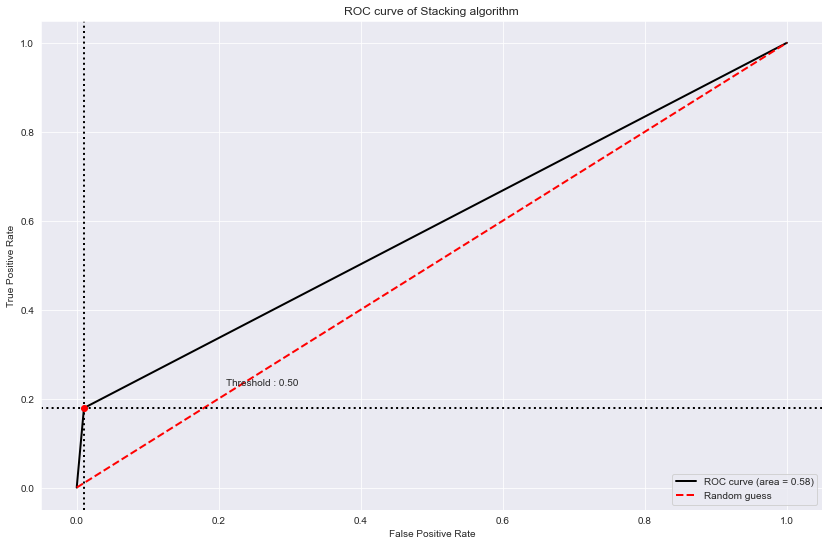

In [65]:
bc = BinaryClassification(y_test, predictions, labels=None)
plt.figure(figsize=(14, 9))
bc.plot_roc_curve()
plt.title('ROC curve of Stacking algorithm')
plt.show()

In [66]:
df2.head(10)

,Algorithm,Accuracy,F1,Precision,Recall
0,Random Forest,80.9,41.945289,62.162162,31.651376
1,Logistic Regression,81.5,32.727273,78.947368,20.642202
2,XGBoost,82.1,43.887147,69.306931,32.110092
3,Naive Bayes,81.3,29.433962,82.978723,17.889908
4,Stacking,80.3,46.612466,56.953642,39.449541


In [67]:
algorithm_list = df2['Algorithm']
accuracy_values = df2['Accuracy']
f1_values = df2['F1']
precision_values = df2['Precision']
recall_values = df2['Recall']

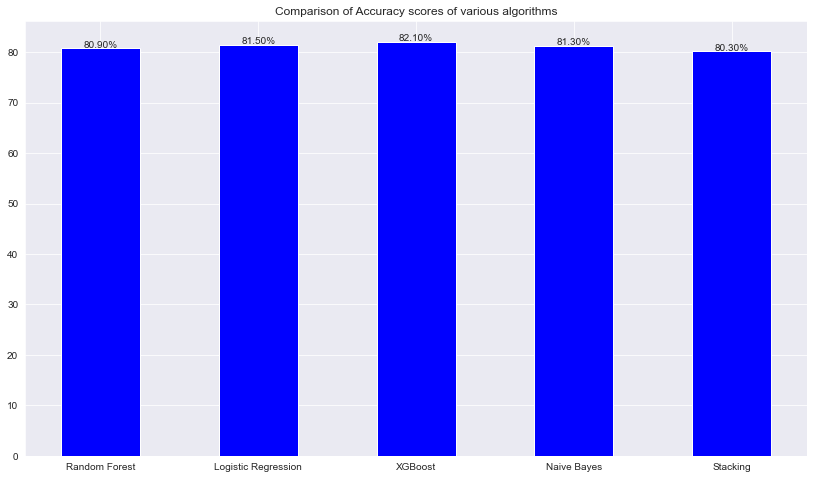

In [68]:
plt.rcParams["figure.figsize"] = [14, 8]

width = 0.5
fig, ax = plt.subplots()

pps = ax.bar(algorithm_list, accuracy_values, width, align='center', color="blue")

for p in pps:
   height = p.get_height()
   ax.text(x=p.get_x() + p.get_width() / 2, y=height+.10, s="{:.2f}%".format(height), ha='center')
plt.title('Comparison of Accuracy scores of various algorithms')
plt.show()

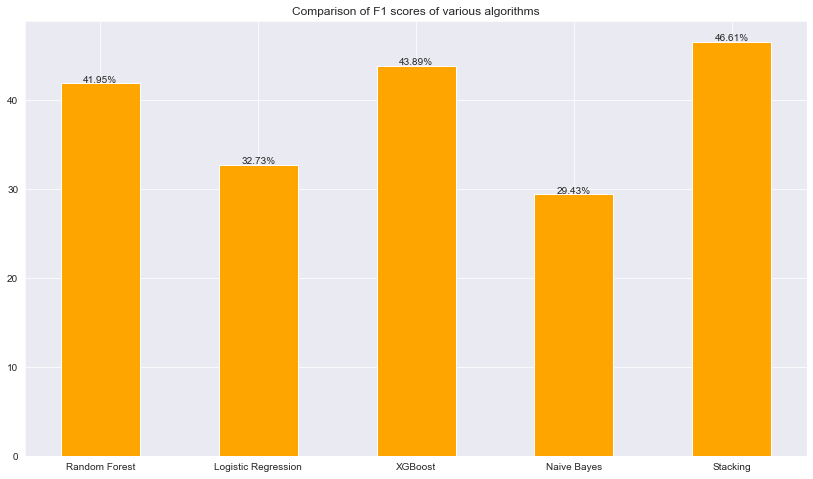

In [69]:
plt.rcParams["figure.figsize"] = [14, 8]

width = 0.5
fig, ax = plt.subplots()

pps = ax.bar(algorithm_list, f1_values, width, align='center', color="orange")

for p in pps:
   height = p.get_height()
   ax.text(x=p.get_x() + p.get_width() / 2, y=height+.10, s="{:.2f}%".format(height), ha='center')
plt.title('Comparison of F1 scores of various algorithms')
plt.show()

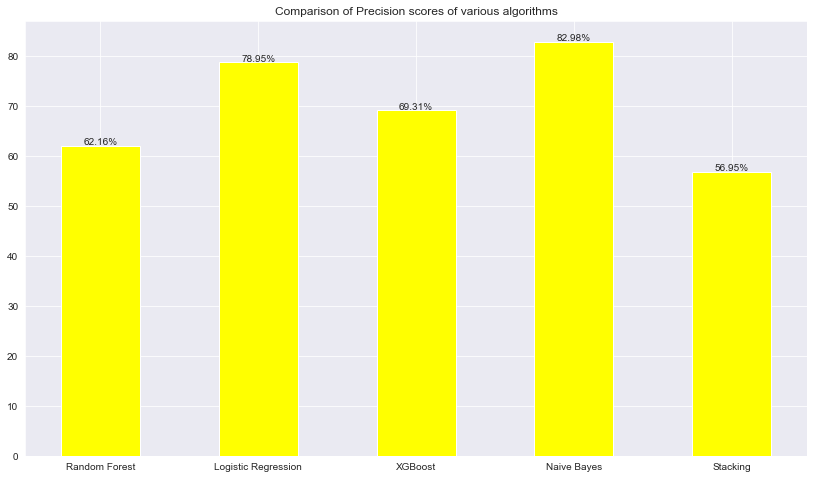

In [70]:
plt.rcParams["figure.figsize"] = [14, 8]

width = 0.5
fig, ax = plt.subplots()

pps = ax.bar(algorithm_list, precision_values, width, align='center', color="yellow")

for p in pps:
   height = p.get_height()
   ax.text(x=p.get_x() + p.get_width() / 2, y=height+.10, s="{:.2f}%".format(height), ha='center')
plt.title('Comparison of Precision scores of various algorithms')
plt.show()

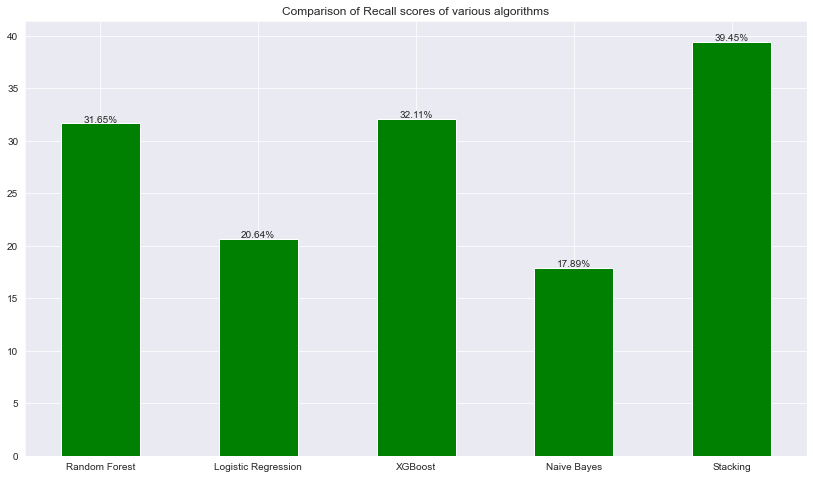

In [71]:
plt.rcParams["figure.figsize"] = [14, 8]

width = 0.5
fig, ax = plt.subplots()
pps = ax.bar(algorithm_list, recall_values, width, align='center', color="green")

for p in pps:
   height = p.get_height()
   ax.text(x=p.get_x() + p.get_width() / 2, y=height+.10, s="{:.2f}%".format(height), ha='center')
plt.title('Comparison of Recall scores of various algorithms')
plt.show()

In [72]:
c1= 'wtf!!! This movie is so good!'
dfnew = pd.DataFrame([c1], columns=['Comment'])
res= preprocess(dfnew['Comment']).to_numpy()
res

array(['wtf movi good'], dtype=object)

In [73]:
comment1_vect = vectorizer.transform(res)
p = model_stack.predict_proba(comment1_vect)
p

array([[0.95273615, 0.04726385]])

In [74]:
output='{0:.{1}f}'.format(p[0][1], 2)

In [75]:
output

'0.05'

In [76]:
if output<str(0.3):
    print("Non hate")
else:
    print ("hate")

Non hate
